In [407]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import math
import time
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward

%matplotlib inline

np.random.seed(1)

In [357]:
X, Y = make_blobs(n_samples=2000, centers=3, n_features=2, cluster_std=1, random_state=0)

In [358]:
X.shape, Y.shape

((2000, 2), (2000,))

In [359]:
X.mean(axis=0), X.var(axis=0)

(array([0.45545506, 2.70081657]), array([3.27079466, 2.85871414]))

In [360]:
X = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)

In [361]:
X.mean(axis=0), X.var(axis=0)

(array([-3.96793709e-16,  4.08006962e-16]), array([1., 1.]))

In [362]:
samples = {}

In [363]:
for i in range(len(np.unique(Y))):
    samples[f"class_{i}"] = X[Y==i]

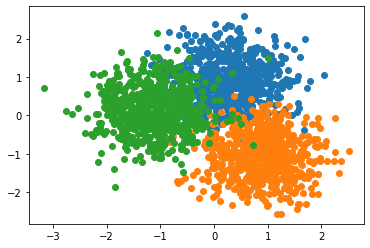

In [364]:
for i in range(len(samples)):
    plt.scatter(samples[f"class_{i}"][:, 0], samples[f"class_{i}"][:, 1])
plt.show()

In [365]:
X = X.T
Y = Y.reshape(1, -1)

In [366]:
print(X.shape)
print(Y.shape)

(2, 2000)
(1, 2000)


In [367]:
#Added better initialization techniques (He and Xavier)
def initialize_parameters_deep(layer_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L-1):
        
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1]) #He Normal Initialization
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
    
    n = layer_dims[L-2]
    m = layer_dims[L-1]
    
    parameters[f"W{L-1}"] = np.random.uniform(low=-(np.sqrt(6) / np.sqrt(n + m)), high=(np.sqrt(6) / np.sqrt(n + m)), size=(m, n)) #Normalized Xavier Uniform Weight Initialization
    parameters[f"b{L-1}"] = np.zeros((m, 1))
    
    return parameters

In [368]:
def linear_forward(A, W, b):
    
    Z = W@A + b
    
    cache = (A, W, b)
    
    return Z, cache

In [369]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    elif activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [370]:
def L_model_forward(X, parameters, keep_prob=1.):
    
    L = len(parameters) // 2
    caches = []
    A = X
    Ds = []
    
    for l in range(1, L):
        
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters[f"W{l}"], parameters[f"b{l}"], "relu")
        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)
        A = A * D
        A = A / keep_prob
        Ds.append(D)
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters[f"W{L}"], parameters[f"b{L}"], "softmax")
    caches.append(cache)
    
    return AL, caches, Ds

In [371]:
#Added L2 regularization
def compute_cost(AL, Y, parameters, lambd):
    
    m = Y.shape[1]
    L = len(parameters) // 2
    sum_of_squared_weights = 0.
    
    log_likelihood = -np.log(AL[Y, range(m)])
    
    categorical_cross_entropy_cost = np.sum(log_likelihood) / m
    
    for l in range(L):
        sum_of_squared_weights += np.sum(np.square(parameters[f"W{l+1}"]))
    
    L2_regularization_cost = lambd/(2*m) * sum_of_squared_weights
    
    cost = categorical_cross_entropy_cost + L2_regularization_cost
    
    return cost

In [372]:
#Modifying gradients because we've changed the cost function
def linear_backward(dZ, cache, lambd):
    
    A_prev, W, b = cache
    
    m = A_prev.shape[1]
    
    dW = 1/m * (dZ@A_prev.T) + lambd/m * W
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = W.T@dZ
    
    return dA_prev, dW, db

In [373]:
def linear_activation_backward(dA, cache, activation, lambd):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)
    
    return dA_prev, dW, db

In [374]:
def L_model_backward(AL, Y, caches, Ds, lambd=0, keep_prob=1.):
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y_hat = np.zeros_like(AL)
    Y_hat[Y, range(m)] = 1
    
    dZ = AL - Y_hat
    current_cache = caches[L-1]
    linear_cache, _ = current_cache
    
    dA_prev_temp, dW_temp, db_temp = linear_backward(dZ, linear_cache, lambd)
    
    dA_prev_temp = dA_prev_temp * Ds[L-2]
    dA_prev_temp = dA_prev_temp / keep_prob
    grads[f"dA{L-1}"] = dA_prev_temp
    grads[f"dW{L}"] = dW_temp
    grads[f"db{L}"] = db_temp
    
    for l in reversed(range(1, L-1)):
        
        current_cache = caches[l]
        D = Ds[l-1]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, "relu", lambd)
        
        dA_prev_temp = dA_prev_temp * D
        dA_prev_temp = dA_prev_temp / keep_prob
        grads[f"dA{l}"] = dA_prev_temp
        grads[f"dW{l+1}"] = dW_temp
        grads[f"db{l+1}"] = db_temp
    
    current_cache = caches[0]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, "relu", lambd)
    grads[f"dA{0}"] = dA_prev_temp
    grads[f"dW{1}"] = dW_temp
    grads[f"db{1}"] = db_temp
        
    return grads

In [383]:
def update_parameters_with_gd(params, grads, learning_rate):
    
    parameters = params.copy()
    L = len(parameters) // 2
    
    for l in range(L):
        parameters[f"W{l+1}"] = parameters[f"W{l+1}"] - learning_rate * grads[f"dW{l+1}"]
        parameters[f"b{l+1}"] = parameters[f"b{l+1}"] - learning_rate * grads[f"db{l+1}"]
        
    return parameters

In [376]:
def fetch_mini_batches(X, Y, mini_batch_size=64, seed=0):
    
    np.random.seed(seed)
    
    m = X.shape[1]
    mini_batches = [] 
    inc = mini_batch_size  
    num_complete_minibatches = math.floor(m / mini_batch_size)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    for i in range(num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:, i*inc:(i+1)*inc]
        mini_batch_Y = shuffled_Y[:, i*inc:(i+1)*inc]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:, num_complete_minibatches*inc:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*inc:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [391]:
def initialize_velocity(parameters):
    
    L = len(parameters) // 2
    v = {}
    
    for l in range(L):
        v[f"dW{l+1}"] = np.zeros_like(parameters[f"W{l+1}"])
        v[f"db{l+1}"] = np.zeros_like(parameters[f"b{l+1}"])
    
    return v

In [393]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    
    L = len(parameters) // 2
    
    for l in range(L):
        
        v[f"dW{l+1}"] = beta * v[f"dW{l+1}"] + (1 - beta) * grads[f"dW{l+1}"]
        v[f"db{l+1}"] = beta * v[f"db{l+1}"] + (1 - beta) * grads[f"db{l+1}"]
        
        parameters[f"W{l+1}"] = parameters[f"W{l+1}"] - learning_rate * v[f"dW{l+1}"]
        parameters[f"b{l+1}"] = parameters[f"b{l+1}"] - learning_rate * v[f"db{l+1}"]
    
    return parameters, v

In [460]:
#Custom function. Not available in the original/corresponding notebook.
def predict(X, Y, parameters):
    
    AL, _, _ = L_model_forward(X, parameters)
    
    predictions = np.argmax(AL, axis=0)
    if Y is not None:
        accuracy = np.average(predictions == Y)
        print(f"Accuracy: {accuracy}")
    else:
        accuracy = None
    
    return accuracy, predictions

In [378]:
#layers_dims = [12288, 20, 7, 5, 1]
layers_dims = [X.shape[0], 30, 10, 3]

In [424]:
# GRADED FUNCTION: L_layer_model (copied from the corresponding notebook)

def L_layer_model(X, Y, layers_dims, optimizer, learning_rate = .001, mini_batch_size=64, beta=.9, lambd = 0, keep_prob = 1., num_iterations = 30000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    seed = 10
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters_deep(layers_dims)
    
    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    
    # YOUR CODE ENDS HERE
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        
        seed = seed + i
        mini_batches = fetch_mini_batches(X, Y, mini_batch_size, seed)
        
        for mini_batch_X, mini_batch_Y in mini_batches:
            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            #(≈ 1 line of code)
            # AL, caches = ...
            # YOUR CODE STARTS HERE
            
            AL, caches, Ds = L_model_forward(mini_batch_X, parameters, keep_prob)
            # YOUR CODE ENDS HERE

            # Compute cost.
            #(≈ 1 line of code)
            # cost = ...
            # YOUR CODE STARTS HERE
            cost = compute_cost(AL, mini_batch_Y, parameters, lambd)

            # YOUR CODE ENDS HERE

            # Backward propagation.
            #(≈ 1 line of code)
            # grads = ...    
            # YOUR CODE STARTS HERE
            grads = L_model_backward(AL, mini_batch_Y, caches, Ds, lambd, keep_prob)

            # YOUR CODE ENDS HERE

            # Update parameters.
            #(≈ 1 line of code)
            # parameters = ...
            # YOUR CODE STARTS HERE
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)

            # YOUR CODE ENDS HERE
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)    
    
    return parameters, costs

In [428]:
parameters, costs = L_layer_model(X, Y, layers_dims, optimizer="gd", learning_rate=1e-3, num_iterations=1000)

Cost after iteration 999: 0.08607017560536984


In [457]:
pred_train, _ = predict(X, Y, parameters)

Accuracy: 0.927


In [550]:
X1_min, X2_min = X[0, :].min() - .5, X[1, :].min() - .5
X1_max, X2_max = X[0, :].max() + .5, X[1, :].max() + .5

X1_range = np.arange(X1_min, X1_max, .1)
X2_range = np.arange(X2_min, X2_max, .1)

X1_, X2_ = np.meshgrid(X1_range, X2_range)

In [551]:
X1_.shape, X2_.shape

((62, 67), (62, 67))

In [554]:
X1, X2 = X1_.flatten(), X2_.flatten()
X1, X2 = X1.reshape((len(X1), 1)), X2.reshape((len(X2), 1))
grid = np.hstack((X1, X2))

In [555]:
grid.shape

(4154, 2)

In [556]:
grid = grid.T

In [557]:
_, predictions = predict(grid, None, parameters)

In [558]:
predictions.shape

(4154,)

In [559]:
predictions = np.expand_dims(predictions, axis=1)

In [560]:
predictions = predictions.reshape(X1_.shape)

In [561]:
predictions.shape

(62, 67)

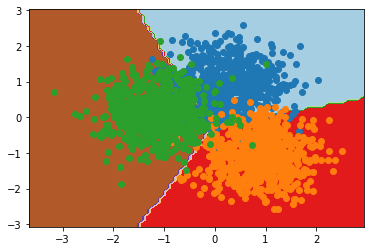

In [562]:
plt.contourf(X1_, X2_, predictions, cmap='Paired')

for class_value in range(3):
    
    row_ix = np.where(Y.T == class_value)
    
    plt.scatter(X[0, row_ix], X[1, row_ix], cmap='Paired')